In [12]:
import os
import re
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
BASE_PATH = "../results/all_limitless/baati"

def readAppData(path, skiprows=28):
    df = pd.read_csv(path, skiprows=skiprows, parse_dates=True)
    df["datetime"] = pd.to_datetime(df["time_h"])
    return df
    
def readResData(path):
    res = pd.read_csv(path)
    res["datetime"] = pd.to_datetime(res["time"], utc=True)
    return res
    
def readExp(expid, base_path=BASE_PATH, node="baati"):
    data_path = glob.glob(os.path.join(base_path, expid, f"VM_runtime_app_*.csv"))[0]
    #res_path = glob.glob(os.path.join(base_path, expid, f"resources/metric_node_*_cpu.csv"))[0]
    return readAppData(data_path), None #readResData(res_path)


def dfInterval(df, tmin, tmax):
    return (tmin <= df["datetime"]) & (df["datetime"] <= tmax)

def getSplitIntervals(df):
    ais = df["ai_name"].unique()
    tss = [df.loc[df["ai_name"] == ai, "datetime"].min() for ai in ais]
    tss.append(df["datetime"].max())
    tss.sort()
    return list(zip(tss[:-1], tss[1:]))

def splitDF(df, timestampDF=None, ai_name="ai_1"):
    if timestampDF is None:
        timestampDF = df
    tss = getSplitIntervals(timestampDF)
    if ai_name is not None:
        df = df[df["ai_name"] == ai_name]
    return [df[dfInterval(df, *ts)] for ts in tss]


def getMetrics(dfs, metric_name="app_latency"):
    metric = np.array([df2[metric_name].mean() for df2 in dfs])
    stddev = np.array([df2[metric_name].std() for df2 in dfs])
    return metric, stddev

def plotPerf(df, expid, metric_name="app_latency"):
    dfs = splitDF(df)
    fig, ax = plt.subplots()
    metric, metric_stddev = getMetrics(dfs)
    ax.errorbar(range(1, len(metric)+1), metric, yerr=metric_stddev)
    ax.set_ylabel(metric_name)
    ax.set_title(expid)
    plt.show()
    
def plotRegressionLine(ax, x, y, yerr, b, expid=None, metric_name="app_latency"): 
    x = np.array(x)
    ax.errorbar(x, y,yerr, color = "m", fmt="o") 
    #plt.scatter(x, y, color = "m", yerr=yerr, 
    #           marker = "o", s = 30) 
    y_pred = b[0] + b[1]*x 
    ax.plot(x, y_pred, color = "g") 
    #plt.show()
    
def getXs(ys):
    return list(range(1, len(ys)+1))

def fitRegression(ys):
    xs2 = [[i] for i in getXs(ys)]
    reg = linear_model.LinearRegression()
    reg.fit(xs2, ys)
    return np.array([reg.intercept_, reg.coef_[0]])

# expid, t1, t2, ai_name, tasks, avg_latency, avg_throughput, std_latency, std_throughput, latency_samples_count
def analizeData(expid, ax, base_path=BASE_PATH, metric_name="app_latency", rescale=False, silent=False):
    print(expid)
    df, res = readExp(expid, base_path=base_path)
    dfs = splitDF(df)
    ys, yerr = getMetrics(dfs, metric_name)
    if rescale:
        factor = ys[0]
        ys /= factor
        yerr /= factor
    coef = fitRegression(ys)
    if not silent:
        plotRegressionLine(ax, getXs(ys), ys, yerr, coef, expid, metric_name)
        #print (f"Coef: {coef}")
        #df[metric_name].plot()
        #plt.show()
        #res["value"].plot()
    return coef


def getCpuSinglePod(expid, role, ts, base_path=BASE_PATH, ai="ai-1"):
    tmin, tmax = ts
    path = glob.glob(os.path.join(base_path, expid, f"resources/metric_pod_*{role}-{ai}*_cpu.csv"))[0]
    res = readResData(path)
    return res.loc[(tmin < res["datetime"]) & (res["datetime"] < tmax), ["datetime", "value"]]

def getCpuLimits(ai_type_role, factor=2.):
    def getExpid(ai_type):
        if ai_type == "redis_ycsb":
            ai_type = "redis"
        return f"{ai_type}_1"
    result = []
    for ai_type, roles in ai_type_role.items():
        expid = getExpid(ai_type)
        print(expid)
        df, _ = readExp(expid)
        tmax = df.loc[df["ai_name"] == "ai_2", "datetime"].min()
        tmin = df.loc[df["ai_name"] == "ai_1", "datetime"].min()
        ts = (tmin, tmax)
        for role in roles:
            res = getCpuSinglePod(expid, role, ts)
            limit = int(res["value"].mean() * factor)
            result.append((ai_type, role, limit))
    return result


def detectExpid(t1, t2, base_path=BASE_PATH, select_fn=max):
    expid = t1 if t1 == t2 else f"{t1}_{t2}"
    def matchExpidRegex(e):
        expid_regex = "[0-9]{0,4}" + expid
        i = e.split("/")[-1]
        return bool(re.fullmatch(expid_regex, i))
    
    pattern = os.path.join(base_path, f"*{expid}")
    expids = glob.glob(pattern)
    expids = [e for e in expids if matchExpidRegex(e)]
    #print(f"there are {len(expids)} results after filtering")
    if not expids:
        raise ValueError(f"Not found any experiment for types {t1} {t2} and glob pattern {pattern}")
    return select_fn(expids)

In [13]:
"""
Check if all experiments have expected number of virtual applications
"""
paths = glob.glob("data/1*")
for path in paths: 
    expid_splitted = path.split("/")
    if len(expid_splitted) < 2:
        print(f"skipping path {path}")
        continue
    expid = expid_splitted[1]
    print(f"Checking {expid}")
    df, _ = readExp(expid, base_path="data")
    print(f"{expid}: {len(df['ai_name'].unique())}")


Checking 106wrk
106wrk: 15
Checking 107wrk_linpack
107wrk_linpack: 15
Checking 105wrk_redis_ycsb
105wrk_redis_ycsb: 15
Checking 104redis_ycsb_hadoop
104redis_ycsb_hadoop: 15
Checking 108wrk_hadoop
108wrk_hadoop: 6
Checking 115hadoop_linpack
115hadoop_linpack: 6
Checking 110linpack_wrk
110linpack_wrk: 14
Checking 118linpack_wrk
118linpack_wrk: 12
Checking 116hadoop
116hadoop: 6
Checking 111linpack
111linpack: 15
Checking 103redis_ycsb_linpack
103redis_ycsb_linpack: 15
Checking 101redis_ycsb
101redis_ycsb: 15
Checking 112linpack_hadoop
112linpack_hadoop: 6
Checking 109linpack_redis_ycsb
109linpack_redis_ycsb: 15
Checking 102redis_ycsb_wrk
102redis_ycsb_wrk: 15
Checking 113hadoop_redis_ycsb
113hadoop_redis_ycsb: 15
Checking 114hadoop_wrk
114hadoop_wrk: 6


# Performance vs cpu

In [106]:
ai_type_role = dict()
ai_type_role["redis_ycsb"] = ["ycsb", "redis"]
ai_type_role["hadoop"] = ["hadoopmaster", "hadoopslave"]
ai_type_role["linpack"] = ["linpack"]
ai_type_role["wrk"] = ["wrk", "apache"]

tasks = ["redis_ycsb", "wrk", "hadoop", "linpack"]
n = len(tasks)

"""
Functions for CPU data parsing.
"""
def toSingleRowDF(d):
    d2 = {}
    for k, v in d.items():
        d2.update({k: pd.Series(v, index=[0])})
    return pd.DataFrame(d2)

# DF: expid, t1, t2, ai_no, ai_role, tasks, avg_cpu, std_cpu, cpu_samples_count
def getResourceDatapoint(expid, t1, t2, ai_no, ai_role, tasks, ts, res):
    res = res.loc[dfInterval(res, *ts), ["datetime", "value"]]
    res = res["value"]
    d = {"expid": expid, "t1": t1, "t2": t2, "ai_no": ai_no+1}
    d.update({"ai_role": ai_role, "tasks": tasks+1})
    d.update({"avg_cpu": res.mean(), "std_cpu": res.std(), "cpu_samples_count": res.count()})
    return toSingleRowDF(d)

def getResourceDatapointsRole(expid, t1, t2, ai_no, ai_role, tss):
    results = pd.DataFrame()
    try:
        path = glob.glob(os.path.join(expid, f"resources/metric_pod_*{ai_role}-ai-{ai_no+1}*_cpu.csv"))[0]
    except IndexError as err:
        raise ValueError(f"No resource record in directory {expid} for ai_role \
            {ai_role} and ai no. {ai_no+1}") from None
        #print(f"No resource record in directory {expid} for ai_role \
        #    {ai_role} and ai no. {ai_no+1}")
    res = readResData(path)
    for tasks in range(ai_no, len(tss)):
        result = getResourceDatapoint(expid, t1, t2, ai_no, ai_role, tasks, tss[tasks], res)
        results = results.append(result, ignore_index=True)
    return results
            
def getResourceDatapoints(expid, t1, t2, ai_nr, tss):
    results = pd.DataFrame()
    t = t1 if not ai_nr else t2
    for ai_role in ai_type_role[t]:
        result = getResourceDatapointsRole(expid, t1, t2, ai_nr, ai_role, tss)
        results = results.append(result, ignore_index=True)
    return results

# cpu, cpu_aggregate, perf_cpu
def getCpuData(tasks, base_path):
    print("Getting cpu data")
    results = pd.DataFrame()
    for t1 in tasks:
        for t2 in tasks:
            expid = detectExpid(t1, t2, base_path)
            df, _ = readExp(expid, base_path="")
            tss = getSplitIntervals(df)
            max_ais = len(tss)
            for ai_no in range(max_ais):
                try:
                    result = getResourceDatapoints(expid, t1, t2, ai_no, tss)
                except ValueError as err:
                    print(err)
                else:
                    results = results.append(result, ignore_index=True)
    return results

def getCpuAggregate(cpu):
    print("Aggregating cpu data")
    cpu_sum = cpu.groupby(["expid", "t1", "t2", "tasks"], as_index=False).sum()
    cpu_sum.pop("ai_no")
    return cpu_sum

def getCpuDataAll(tasks, base_path):
    cpu = getCpuData(tasks, base_path)
    agg = getCpuAggregate(cpu)
    return {"cpu": cpu, "cpu_agg": agg}


"""
Functions for performance data parsing.
"""
# expid, t1, t2, ai_name, tasks
def getPerfAggregate(input_df):
    print("Aggregating perf data")
    results = pd.DataFrame()
    for expid in input_df["expid"].unique():
        df = input_df[input_df["expid"] == expid]
        tss = getSplitIntervals(df)
        ai_count = len(tss)
        for ai_no in range(ai_count):
            for tasks in range(ai_no, ai_count):
                ai_name = f"ai_{ai_no+1}"
                local_df = df[dfInterval(df, *tss[tasks]) & (df["ai_name"] == ai_name)]
                d = {"expid": expid, "ai_no": ai_no+1, "tasks": tasks+1}
                for metric in ["app_latency", "app_throughput"]:
                    if np.any(pd.isna(local_df[metric])):
                        continue
                    perf = local_df[metric]
                    m = metric[len("app_"):]
                    d.update({f"avg_{m}": perf.mean(), f"std_{m}": perf.std()})
                    d.update({f"{m}_samples_count": perf.count()})
                results = results.append(toSingleRowDF(d), ignore_index=True)
    return results

def getPerfData(expids):
    print("Getting perf data")
    results = pd.DataFrame()
    for expid in expids:
        df, _ = readExp(expid, base_path="")
        df["expid"] = expid
        results = results.append(df, ignore_index=True)
    return results
                
def getPerfDataAll(tasks, base_path):
    expids = [detectExpid(t1, t2, base_path) for t1 in tasks for t2 in tasks]
    perf = getPerfData(expids)
    agg = getPerfAggregate(perf)
    return {"perf": perf, "perf_agg": agg}
    
def getPerfVsCpu(cpu_res, perf_res):
    result = {}
    result.update(cpu_res)
    result.update(perf_res)
    result["perf_vs_cpu"] = result["cpu_agg"].merge(result["perf_agg"], on=["expid", "tasks"])
    return result
    
    
"""
Functions for analyzing performance vs cpu.
"""
task_to_color = {"redis_ycsb": "green", "wrk": "blue", "linpack": "yellow", "hadoop": "red"}
def printPerfVsCpu(input_df, rescale=True):
    t1s = input_df["t1"].unique()
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs = [ax for axs1 in axs for ax in axs1]
    if len(t1s) == 1:
        axs = [axs]
        
    for i, t1 in enumerate(t1s):
        metric = "throughput" if t1 == "linpack" else "latency"
        avg_metric = f"avg_{metric}"
        std_metric = f"avg_{metric}"
        axs[i].set_title(f"performance of {t1}")
        df = input_df.loc[(input_df["t1"] == t1) & (input_df["ai_no"] == 1), :]
        if rescale:
            factor = df.loc[(df["tasks"] == 1), avg_metric].mean()
            df.loc[:, avg_metric] /= factor
            df.loc[:, std_metric] /= factor
        for t2 in sorted(df["t2"].unique()):
            df2 = df.loc[df["t2"] == t2, :]
            #axs[i].scatter(df2["avg_cpu"], df2[avg_metric], color=task_to_color[t2], label=t2)
            axs[i].scatter(df2["avg_cpu"], df2[avg_metric], label=t2)
        axs[i].legend()
    plt.show()

def analyzePerfVsCpu(tasks, base_path=BASE_PATH):
    print(f"perf vs cpu {base_path}")
    cpu_res = getCpuDataAll(tasks, base_path)
    perf_res = getPerfDataAll(tasks, base_path)
    result = getPerfVsCpu(cpu_res, perf_res)
    printPerfVsCpu(result["perf_vs_cpu"])
    return result

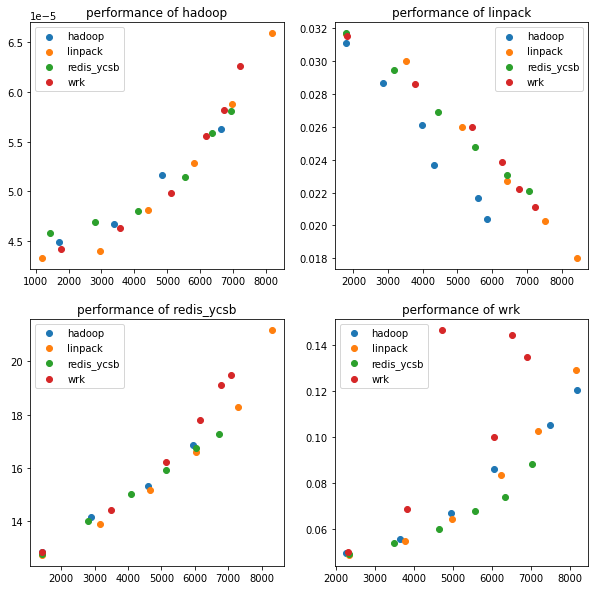

In [107]:
#perf_vs_cpu_res = analyzePerfVsCpu(tasks)
printPerfVsCpu(perf_vs_cpu_res["perf_vs_cpu"])

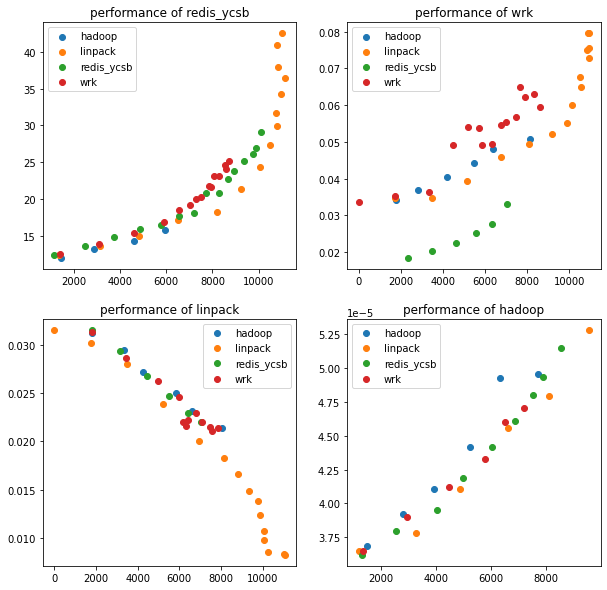

In [108]:
#perf_vs_cpu_res_new = analyzePerfVsCpu(tasks, base_path="data")
printPerfVsCpu(perf_vs_cpu_res_new["perf_vs_cpu"])

In [90]:
perf = perf_vs_cpu_res_new["perf_agg"]
#perf.info()
t1 = "linpack"
t2 = t1
expid = "data/111linpack"
perf["expid"].unique()
r = perf.loc[(perf["expid"] == expid) & (perf["ai_no"] <= perf["tasks"]) & (perf["throughput_samples_count"].notna()),["tasks", "ai_no", "throughput_samples_count"]]
r.describe()

,tasks,ai_no,throughput_samples_count
count,120.000000,120.000000,120.000000
mean,10.333333,5.666667,49.500000
std,3.651484,3.651484,23.723194
min,1.000000,1.000000,23.000000
25%,8.000000,3.000000,34.000000
50%,11.000000,5.000000,41.500000
75%,13.000000,8.000000,59.000000
max,15.000000,15.000000,126.000000


# Performance vs number of tasks

../results/all_limitless/baati/4redis_ycsb
../results/all_limitless/baati/1redis_ycsb_wrk
../results/all_limitless/baati/1redis_ycsb_hadoop
../results/all_limitless/baati/1redis_ycsb_linpack
../results/all_limitless/baati/1wrk_redis_ycsb
../results/all_limitless/baati/1wrk
../results/all_limitless/baati/1wrk_hadoop
../results/all_limitless/baati/1wrk_linpack
../results/all_limitless/baati/3hadoop_redis_ycsb
../results/all_limitless/baati/1hadoop_wrk
../results/all_limitless/baati/3hadoop
../results/all_limitless/baati/1hadoop_linpack
../results/all_limitless/baati/1linpack_redis_ycsb
../results/all_limitless/baati/1linpack_wrk
../results/all_limitless/baati/1linpack_hadoop
../results/all_limitless/baati/1linpack


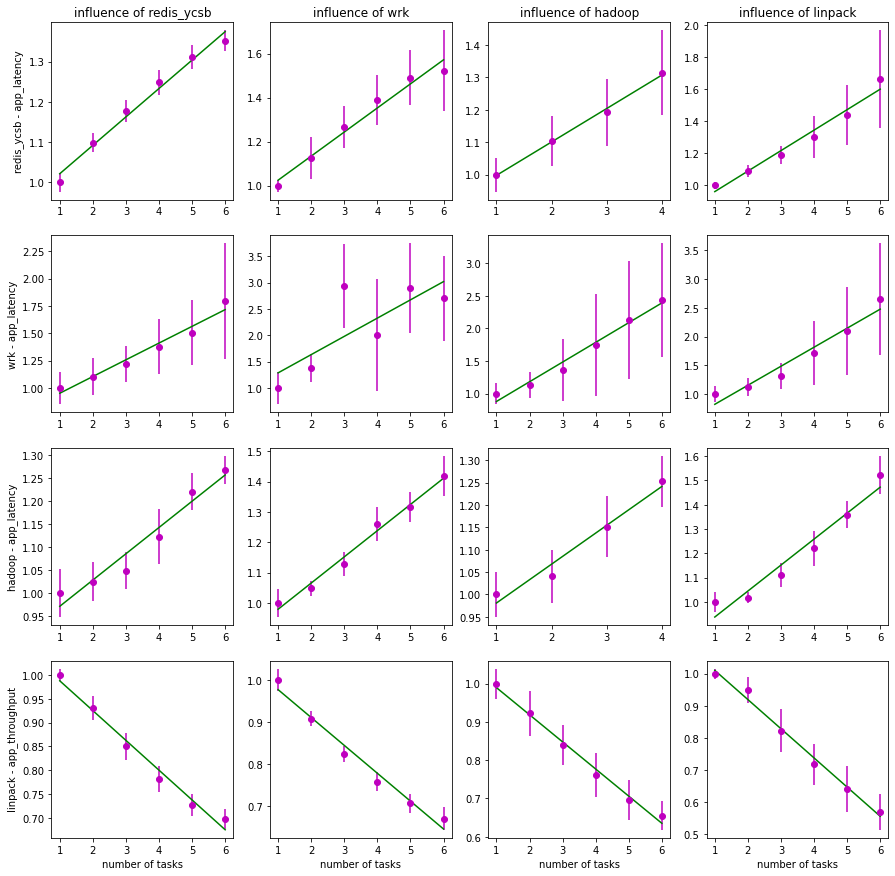

[[0.07063209 0.10939086 0.10299651 0.12770357]
 [0.15296261 0.34636941 0.30279389 0.33084764]
 [0.05702027 0.08645344 0.08695757 0.10692214]
 [0.06254286 0.06645851 0.0709298  0.09099933]]


In [7]:
"""
# TODO print cost function
"""
tasks = ["redis_ycsb", "wrk", "hadoop", "linpack"]
def getExpRecord(t1, t2, base_path, select_fn=max):
    result = {}
    result["expid"] = detectExpid(t1, t2, base_path=base_path, select_fn=select_fn)
    result["t1"] = t1
    result["t2"] = t2
    result["metric"] = "app_throughput" if t1 == "linpack" else "app_latency"
    result["sign"] = -1. if result["metric"] == "app_throughput" else 1.
    return result

def analyzeInterferenceGrid(tasks, skip_tasks=[], base_path=BASE_PATH, rescale=True, silent=False):
    results = []
    n = len(tasks)
    def formatLegend(ax, exp, i, j):
        if j == n-1:
            ax.set_xlabel('number of tasks') 
        if not j:
            ax.set_title(f"influence of {exp['t2']}")
        if not i:
            ax.set_ylabel(f"{exp['t1']} - {exp['metric']}") 
    exps = [getExpRecord(t1, t2, base_path) for t1 in tasks for t2 in tasks]
    fig, axes = plt.subplots(n, n, figsize=(15., 15.))
    for i, exp,  in enumerate(exps):
        j, k = int(i / n), int(i % n)
        ax = axes[j, k]
        formatLegend(ax, exp, k, j)
        if (exp["t1"], exp["t2"]) in skip_tasks:
            results.append(0.)
        else:
            coefs = analizeData(exp["expid"], ax, base_path="", metric_name=exp["metric"], \
                                rescale=rescale, silent=silent)
            results.append(coefs[1] * exp["sign"])
    plt.show()
    results = np.array(results)
    results.resize([n, n])
    return np.array(results)

interference = analyzeInterferenceGrid(tasks)
print(interference)

data/101redis_ycsb
data/102redis_ycsb_wrk
data/103redis_ycsb_linpack
data/106wrk
data/108wrk_hadoop
data/107wrk_linpack
data/114hadoop_wrk
data/116hadoop
data/115hadoop_linpack
data/109linpack_redis_ycsb
data/118linpack_wrk
data/112linpack_hadoop
data/111linpack


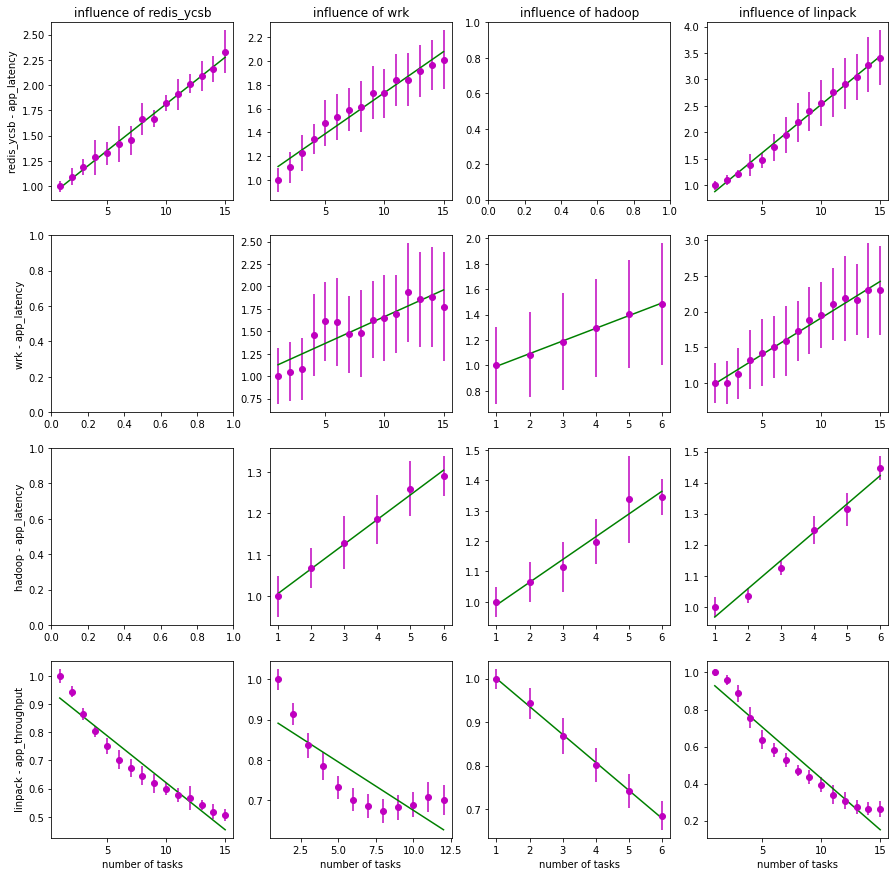

[[0.09251838 0.06896643 0.         0.18303585]
 [0.         0.05950165 0.0996998  0.10239049]
 [0.         0.05943509 0.07495003 0.0910561 ]
 [0.03340253 0.02394899 0.06426189 0.05550344]]


In [50]:
skip_tasks = [("wrk", "redis_ycsb"), ("hadoop", "redis_ycsb"), ("redis_ycsb", "hadoop")]
interference = analyzeInterferenceGrid(tasks, skip_tasks=skip_tasks, base_path="data")
print(interference)

data/110linpack_wrk
data/118linpack_wrk


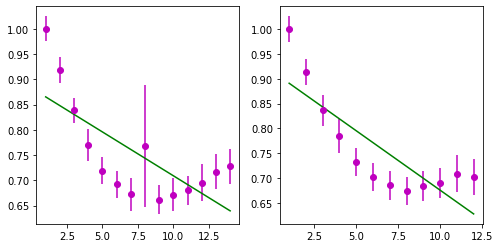

In [31]:
t1 = "linpack"
t2 = "wrk"
exps = [getExpRecord(t1, t2, base_path="data", select_fn=f) for f in [min, max]]
fig, axs = plt.subplots(1, 2, figsize=(8., 4.))
for i, exp in enumerate(exps):
    ax = axs[i]
    coefs = analizeData(exp["expid"], ax, base_path="", metric_name=exp["metric"], \
                        rescale=True, silent=False)
plt.show()

../results/all_limitless/naan/45redis_ycsb
../results/all_limitless/naan/52redis_ycsb
../results/all_limitless/naan/53redis_ycsb


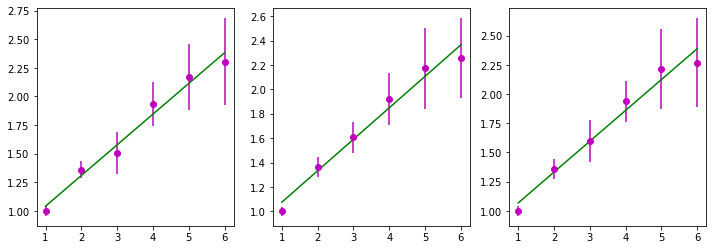

In [34]:
t1 = "redis_ycsb"
t2 = t1
def getExpRecord(t1, t2, base_path, select_fn):
    result = {}
    result["expid"] = detectExpid(t1, t2, base_path=base_path, select_fn=select_fn)
    result["t1"] = t1
    result["t2"] = t2
    result["metric"] = "app_throughput" if t1 == "linpack" else "app_latency"
    result["sign"] = -1. if result["metric"] == "app_throughput" else 1.
    return result

exps = [getExpRecord(t1, t2, "../results/all_limitless/naan", lambda x: x[i]) for i in range(3)]
fig, axs = plt.subplots(1, 3, figsize=(12., 4.))
for i, exp in enumerate(exps):
    ax = axs[i]
    coefs = analizeData(exp["expid"], ax, base_path="", metric_name=exp["metric"], \
                        rescale=True, silent=False)
plt.show()

data/naan/150redis_ycsb
data/naan/155wrk


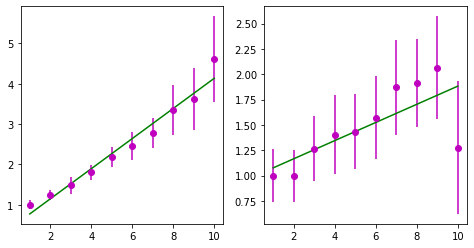

In [6]:
t1 = "redis_ycsb"
t2 = t1
def getExpRecord(t1, t2, base_path, select_fn):
    result = {}
    result["expid"] = detectExpid(t1, t2, base_path=base_path, select_fn=select_fn)
    result["t1"] = t1
    result["t2"] = t2
    result["metric"] = "app_throughput" if t1 == "linpack" else "app_latency"
    result["sign"] = -1. if result["metric"] == "app_throughput" else 1.
    return result

exps = [getExpRecord(t, t, "data/naan", max) for t in ["redis_ycsb", "wrk"]]
fig, axs = plt.subplots(1, 2, figsize=(8., 4.))
for i, exp in enumerate(exps):
    ax = axs[i]
    coefs = analizeData(exp["expid"], ax, base_path="", metric_name=exp["metric"], \
                        rescale=True, silent=False)
plt.show()

12.0


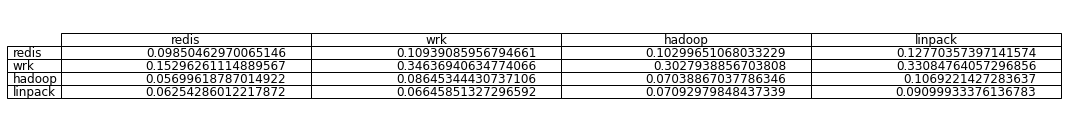

In [24]:
fig, ax = plt.subplots()
fig.patch.set_visible(False)
fig.set_size_inches((15, 2))
ax.axis("off")
ax.axis("tight")

def_size = plt.rcParams["font.size"]
plt.rcParams.update({"font.size": 12.})
print(def_size)


df = pd.DataFrame(inference, columns=tasks)
ax.table(cellText=df.values, colLabels=df.columns,rowLabels=tasks, loc="center")
fig.tight_layout()
plt.show()